# Note on the Diffusion model

<a href="https://colab.research.google.com/github/ioskn/mldl_htwg/blob/master/diffusion/diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Forward pass simulation of the transition Kernel

To understand the transition kernel consider the transition of $x_{t-1}$ from $t-1$ to $x_t$.

$$
 q(x_t|x_{t-1})=N(\sqrt{1-\beta_t} x_{t-1},\beta_t) 
$$ 
NB: that the Normal above is parameterized by mean and **variance deviation**. Whereas the numpy function `np.random.normal` is parameterized by mean and **standard deviation**.


Given (conditioned) on $x_{t-1}$ $x_t$ is a Gaussian with mean $\sqrt{1-\beta_t} x_{t-1}$ and variance $\beta_t$. We can also write this as

$$
 x_t = x_{t-1} \cdot \sqrt{1-\beta_t} + \sqrt{\beta_t} \cdot \epsilon \quad \epsilon \sim N(0,1)
$$ 

### Simulation of the forward pass
Let's do a simulation. We start at $t=0$ from an initial distribution $x_0 \sim q(x_0)$.

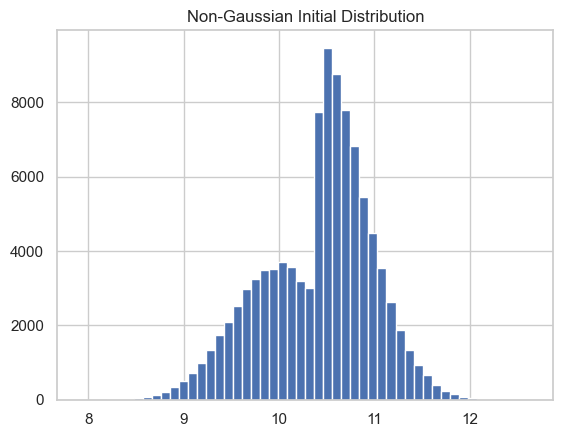

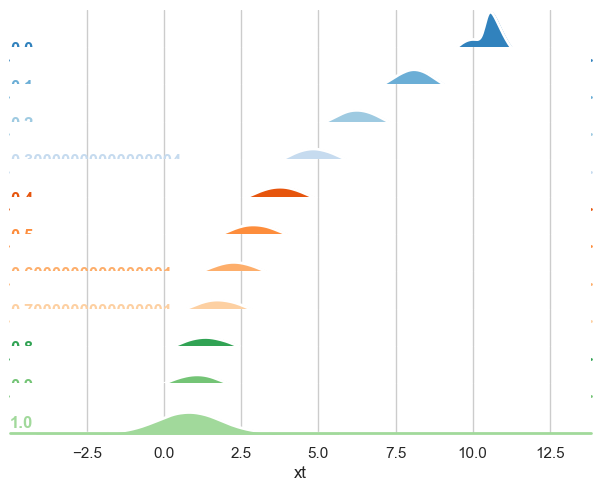

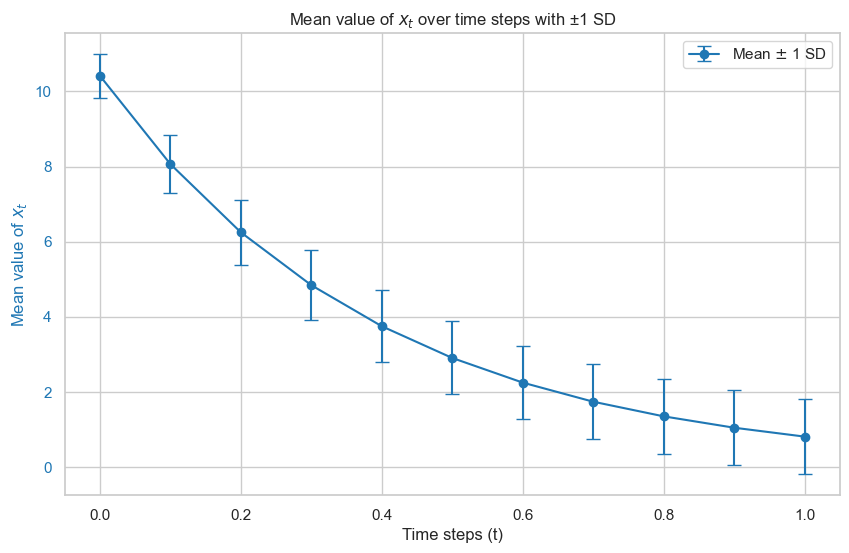

In [82]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Reproducing the R code in Python
N = int(1e5)
steps = 10
beta = 0.4
#### Bimodal Distribution ####
xt = np.random.normal(10.42, 0.5, N)
xt[xt < 10.4] = np.random.normal(10, 0.5, len(xt[xt < 10.4]))
xt0=xt
plt.hist(xt, bins=50)
plt.title('Non-Gaussian Initial Distribution')


t = 0
df = pd.DataFrame({
    't': [t] * N,
    'xt': xt
})

for i in range(1, steps + 1):
    t = t + 1
    xt = np.random.normal(np.sqrt(1-beta) * xt, scale=np.sqrt(beta)) #<-- Transition Kernel
    temp_df = pd.DataFrame({'t': [t] * N, 'xt': xt})
    df = pd.concat([df, temp_df])


########## Below is plotting code only ##########
# Normalize 't' to use as y-axis value
scaler = MinMaxScaler()
df['t_org'] = df[['t']]
df['t'] = scaler.fit_transform(df[['t']])

# Plot using seaborn's kdeplot for ridge plot
sns.set(style="whitegrid")
g = sns.FacetGrid(df, row='t', hue='t', aspect=15, height=0.5, palette="tab20c")

# Draw the densities in a few steps
g.map(sns.kdeplot, 'xt', clip_on=False, shade=True, alpha=1, lw=1.5, bw=0.2)
g.map(sns.kdeplot, 'xt', clip_on=False, color="w", lw=2, bw=0.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "xt")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-0.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

# Show the plot
plt.show()

# Print the mean and standard deviation of the final xt
mean_xt = np.mean(xt)
sd_xt = np.std(xt)
mean_xt, sd_xt

# Creating a new DataFrame to store the mean and standard deviation at each time step
mean_sd_df = df.groupby('t').agg(
    mean_xt=('xt', 'mean'),
    sd_xt=('xt', 'std')
).reset_index()

# Creating a plot with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting the mean values of xt
ax1.errorbar(mean_sd_df['t'], mean_sd_df['mean_xt'], 
             yerr=mean_sd_df['sd_xt'], fmt='-o', capsize=5,
             label='Mean $\pm$ 1 SD', color='tab:blue')
ax1.set_xlabel('Time steps (t)')
ax1.set_ylabel('Mean value of $x_t$', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Adding a title
plt.title('Mean value of $x_t$ over time steps with ±1 SD')

# Adding a legend
ax1.legend()

plt.show()

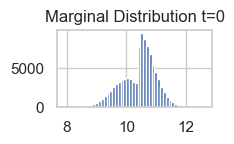

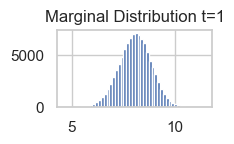

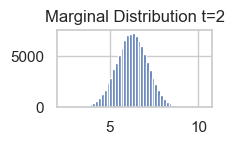

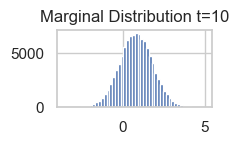

In [83]:
#super small figures
for t in (0,1,2,steps):#range(0, steps):
    plt.figure(figsize=(2, 1))
    xt = df[df['t_org'] == t]['xt']
    plt.hist(xt, bins=50)
    plt.title(f'Marginal Distribution t={t}')
    plt.show()

### Direct Jump

We can directly jump to $x_t$ by sampling from $q(x_t|x_0) = N(x_t; \sqrt{\bar{\alpha_t}} x_0, (1-\bar{\alpha_t}))$.


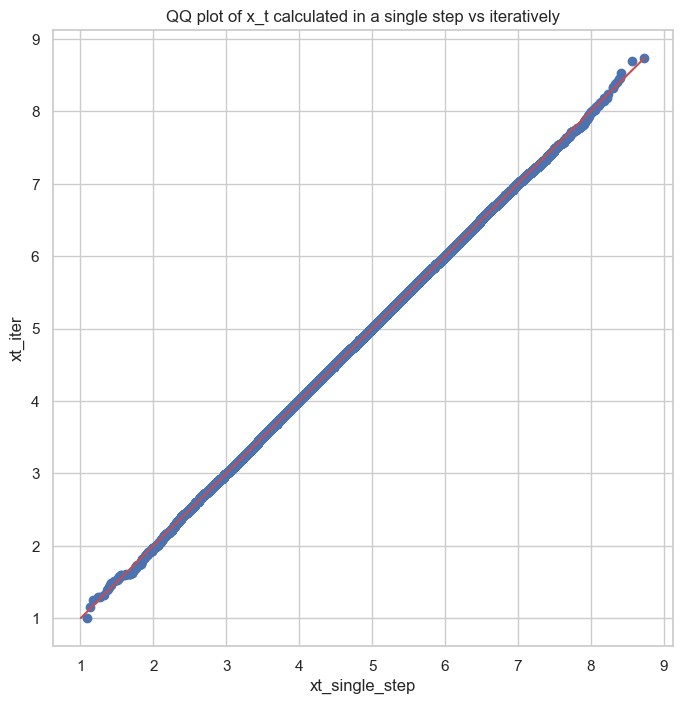

In [88]:
t = 3

# Iteratively calculate the marginal distribution
xt_iter = df[df['t_org'] == t]['xt']


# Direct stops
alpha_t = (1 - beta)**t
#xt_direct = np.random.normal(xt0 * np.sqrt(alpha_t), np.sqrt(1. - alpha_t), N) 
xt_single_step = xt0 * np.sqrt(alpha_t) +  np.sqrt(1. - alpha_t) * np.random.normal(0, 1, N) 
np.mean(xt_single_step), np.std(xt_single_step),np.mean(xt_iter), np.std(xt)

############## Below is plotting code only ##############
# Sort the data
xt_sorted = np.sort(xt_iter)
xt_direct_sorted = np.sort(xt_single_step)

# Create the QQ plot
plt.figure(figsize=(8, 8))
plt.plot(xt_direct_sorted, xt_sorted, 'o')
plt.xlabel('xt_single_step')
plt.ylabel('xt_iter')
plt.title('QQ plot of x_t calculated in a single step vs iteratively')
plt.plot([np.min((xt_direct_sorted[0], xt_sorted[0])), np.max((xt_direct_sorted[-1], xt_sorted[-1]))], 
         [np.min((xt_direct_sorted[0], xt_sorted[0])), np.max((xt_direct_sorted[-1], xt_sorted[-1]))], 'r-')
plt.show()